In [10]:
import math
import pandas as pd
import tqdm
import numpy as np
import pathlib

import torch
import torch.utils.data as data
import torch.optim as optim

from MINE import controller, datasets, losses, models

In [11]:
def experiment(loss_name, batch_size):
    data_loader = data.DataLoader(
        datasets.IntegerPairDataset(
            number_of_cases=16,
            x_encoding='one_hot',
            y_encoding='one_hot',
            transform=datasets.TransformToTensor()
        ),
        batch_size=batch_size,
    )
    loss = getattr(losses, f'{loss_name}_loss')()
    network = models.ConcatNet(16, 64)
    optimizer = optim.SGD(network.parameters(), lr=0.1)

    agent = controller.MINEController(
        data_loader=data_loader, loss=loss, network=network, optimizer=optimizer
    )

    agent_path = f'observing_onehot_{loss_name}_{batch_size}.pth'
    if pathlib.Path(agent_path).exists():
        print(f'Loading {agent_path}')
        agent.load(agent_path)
    else:
        agent.to(0)
        agent.train()
        for i in tqdm.tqdm(range(3000)):
            agent.step()
        agent.save(agent_path)

    return agent

In [12]:
loss_name = {'nwj': 'NWJ', 'renwj': 'ReNWJ', 'mine': 'MINE', 'remine': 'ReMINE'}

def get_t(agent, batch_size):
    t = []
    for i in range(0, len(agent.history), batch_size):
        t.append(np.average(agent.history.joint_value[i:i+batch_size]))
    return np.array(t)

def get_et(agent, batch_size, method):
    et = []
    if method == 'mine' or method == 'remine':
        for i in range(0, len(agent.history), batch_size):
            et.append(np.log(np.average(np.exp(agent.history.marginal_value[i:i+batch_size]))))
    elif method == 'nwj' or method == 'renwj':
        for i in range(0, len(agent.history), batch_size):
            et.append(np.average(np.exp(agent.history.marginal_value[i:i+batch_size]))-1)
    else:
        raise Exception()
    return et

Loading observing_onehot_nwj_32.pth


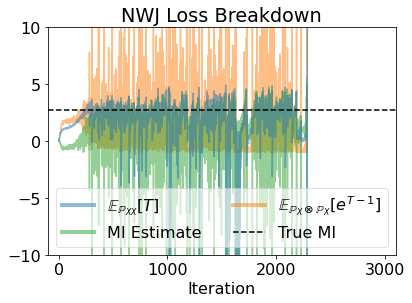

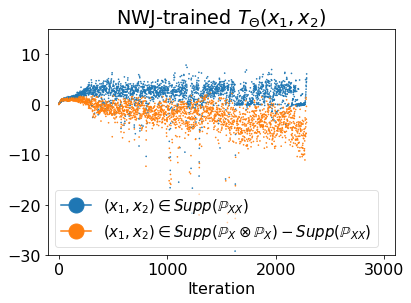

Loading observing_onehot_nwj_100.pth


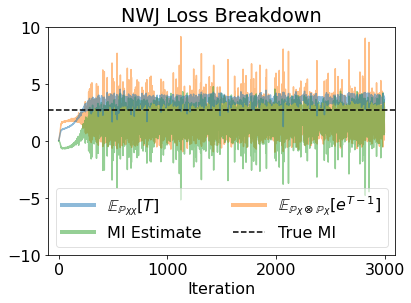

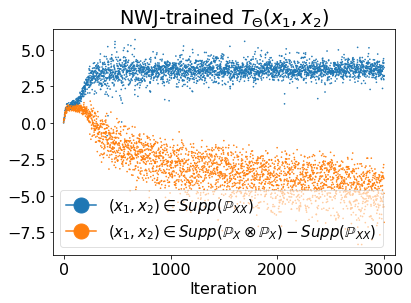

Loading observing_onehot_mine_32.pth


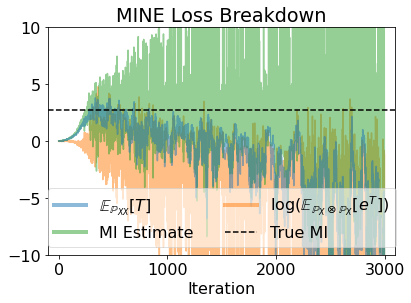

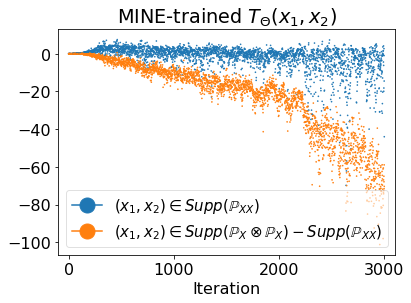

Loading observing_onehot_mine_100.pth


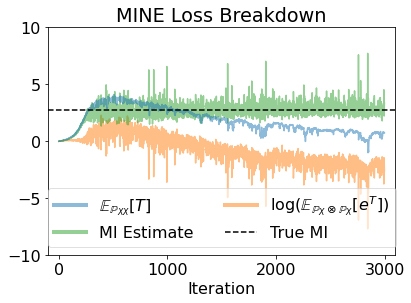

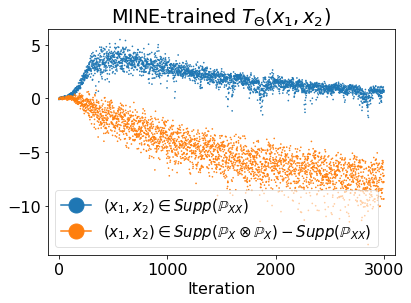

Loading observing_onehot_renwj_32.pth


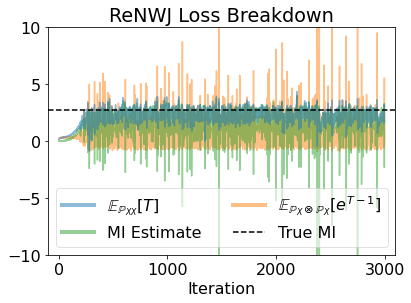

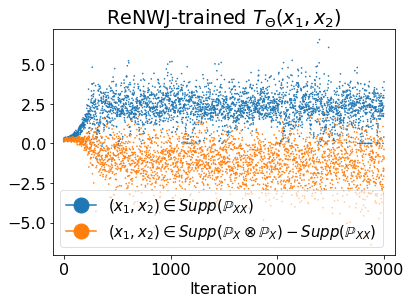

Loading observing_onehot_renwj_100.pth


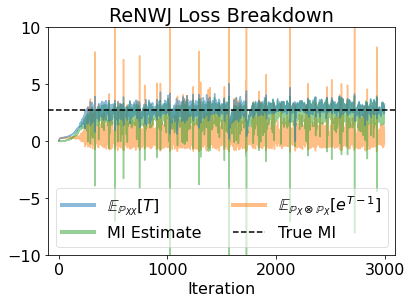

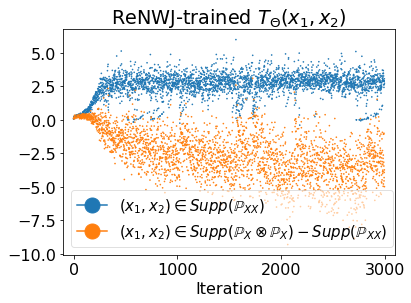

Loading observing_onehot_remine_32.pth


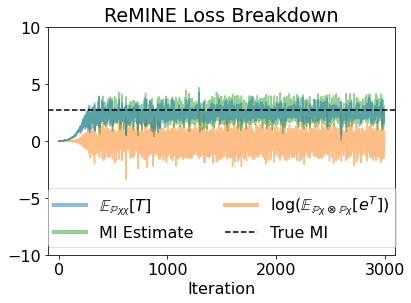

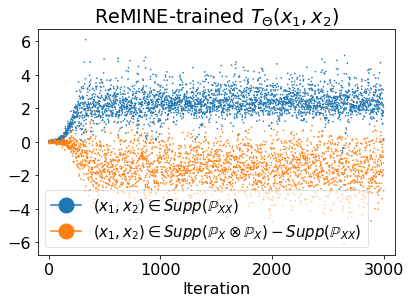

Loading observing_onehot_remine_100.pth


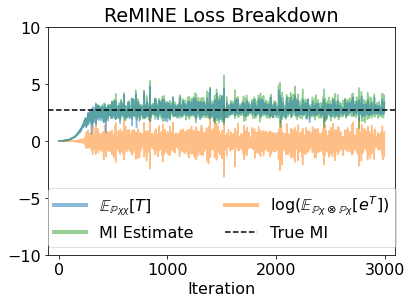

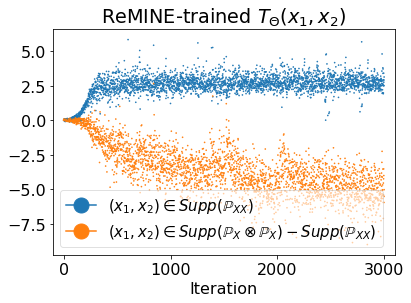

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

for l in ('nwj', 'mine', 'renwj', 'remine'):
    for bs in (32, 100):
        agent = experiment(l, bs)
        t = get_t(agent, bs)
        et = get_et(agent, bs, l)
        mi = t - et

        plt.rcParams.update({'font.size': 16})
        plt.figure(figsize=(6, 4.5))
        
        if 'nwj' in l:
            label_text = '$\mathbb{E}_{\mathbb{P}_X \otimes \mathbb{P}_X}[e^{T-1}]$'
        else:
            label_text = '$\log(\mathbb{E}_{\mathbb{P}_X \otimes \mathbb{P}_X}[e^{T}])$'
        plt.plot(et, alpha=0.5, label=label_text, c='C1')
        plt.plot(mi, alpha=0.5, label='MI Estimate', c='C2')
        plt.plot(t, alpha=0.5, label='$\mathbb{E}_{\mathbb{P}_{X X}}[T]$', c='C0')
        plt.axhline(np.log(16),label='True MI', color='black', ls='--', alpha=1.0)

        handles, labels = plt.gca().get_legend_handles_labels()
        order = [2, 1, 0, 3]
        lg = plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], loc='lower center', ncol=2, framealpha=0.6, fontsize='medium')

        plt.setp(lg.get_lines()[:3], linewidth=4)
        plt.ylim(-10, 10)
        plt.yticks([-10, -5, 0, 5, 10])
        plt.tight_layout()
        plt.xlabel("Iteration")
        plt.xticks(list(range(0, 3001, 1000)))
        plt.xlim(-100, 3100)

        plt.title(f'{loss_name[l]} Loss Breakdown')
        plt.tight_layout()
        plt.savefig(f'{l}-batch{bs}-plot.pdf')
        plt.show()

        plt.figure(figsize=(6, 4.5))

        _df = agent.history[::bs]
        sct = plt.scatter(
            list(range(len(_df))) + list(range(len(_df))),
            list(_df.joint_value) + list(_df.marginal_value),
            s=0.4, alpha=1,
            c=['C0' for i in _df.is_joint_case] + ['C0' if i else 'C1' for i in _df.is_joint_case]
        )

        custom_lines = [Line2D([0], [0], marker='o', markersize=15, color='C0'),
                        Line2D([0], [0], marker='o', markersize=15, color='C1')]
        if l == 'nwj' and bs == 32:
            plt.ylim(-30, 15)

        plt.legend(
            custom_lines,
            ['$(x_1, x_2) \in Supp(\mathbb{P}_{X X})$', 
             '$(x_1, x_2) \in Supp(\mathbb{P}_X \otimes \mathbb{P}_X)-Supp(\mathbb{P}_{X X})$',],
            framealpha=0.6,
            fontsize=15
        )
        plt.title(f'{loss_name[l]}' + '-trained $T_{\Theta}(x_1, x_2)$')
        plt.xlabel("Iteration")
        plt.xticks(list(range(0, 3001, 1000)))
        plt.xlim(-100, 3100)
        plt.tight_layout()
        plt.savefig(f'{l}-batch{bs}-scatter.pdf')
        plt.show()